# W8 - Project

### Case Study - The site for recommendations - "Gnod"
Scenario
You have been hired as a Data Analyst for “Gnod”.

“Gnod” is a site that provides recommendations for music, art, literature and products based on collaborative filtering algorithms. Their flagship product is the music recommender, which you can try at www.gnoosic.com. The site asks users to input 3 bands they like, and computes similarity scores with the rest of the users. Then, they recommend to the user bands that users with similar tastes have picked.

“Gnod” is a small company, and its only revenue stream so far are adds in the site. In the future, they would like to explore partnership options with music apps (such as Deezer, Soundcloud or even Apple Music and Spotify). However, for that to be possible, they need to expand and improve their recommendations.

That’s precisely where you come. They have hired you as a Data Analyst, and they expect you to bring a mix of technical expertise and business mindset to the table.

Jane, CTO of Gnod, has sent you an email assigning you with your first task.

### Task(s)
This is an e-mail Jane - CTO of Gnod - sent over your inbox in the first weeks working there.

Dear xxxxxxxx, We are thrilled to welcome you as a Data Analyst for Gnoosic!

As you know, we are trying to come up with ways to enhance our music recommendations. One of the new features we’d like to research is to recommend songs (not only bands). We’re also aware of the limitations of our collaborative filtering algorithms, and would like to give users two new possibilities when searching for recommendations:

Songs that are actually similar to the ones they picked from an acoustic point of view.
Songs that are popular around the world right now, independently from their tastes.
Coming up with the perfect song recommender will take us months - no need to stress out too much. In this first week, we want you to explore new data sources for songs. The Internet is full of information and our first step is to acquire it do an initial exploration. Feel free to use APIs or directly scrape the web to collect as much information as possible from popular songs. Eventually, we’ll need to collect data from millions of songs, but we can start with a few hundreds or thousands from each source and see if the collected features are useful.

Once the data is collected, we want you to create clusters of songs that are similar to each other. The idea is that if a user inputs a song from one group, we’ll prioritize giving them recommendations of songs from that same group.

On Friday, you will present your work to me and Marek, the CEO and founder. Full disclosure: I need you to be very convincing about this whole song-recommender, as this has been my personal push and the main reason we hired you for!

Be open minded about this process: we are agile, and that means that we define our products and features on-the-go, while exploring the tools and the data that’s available to us. We’d love you to provide your own vision of the product and the next steps to be taken.

Lots of luck and strength for this first week with us!

-Jane

## Loading libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from time import sleep
import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Scraping

In [2]:
url_200 = "https://www.billboard.com/charts/billboard-200"

def scrap_hot200(url):
    response = requests.get(url)
    response.status_code
    soup = BeautifulSoup(response.content, "html.parser")
    soup.select("ol")
    song_name = soup.find_all("span", "chart-element__information__song text--truncate color--primary")
    artist_name = soup.find_all("span", "chart-element__information__artist text--truncate color--secondary")
    
    artist_200 = []
    song_200 = []
    num_iter = len(artist_name)

    for i in range(num_iter):
        artist_200.append(artist_name[i].get_text())
        song_200.append(song_name[i].get_text())
        
    return artist_200, song_200

In [3]:
song_200, artist_200 = scrap_hot200('https://www.billboard.com/charts/billboard-200')

In [4]:
def clean_artist(artist_name):
    '''removes characters from artist name that are
    contained in break_list 
    i.e. 
    break_list = [ ' featuring ', ' x ', ' & ', 'with']'''
        
    break_list = [ ' featuring ', ' x ', ' & ', ' with']
    for break_point in break_list:
        artist_name = artist_name.replace(break_point,' ')
    
    return artist_name

In [5]:
def hot200_df(list_song, list_artist):
    songs_200 = pd.DataFrame({"song":list_song,
                       "artist":list_artist,
                      })
    songs_200['song_lower'] = songs_200['song'].apply(lambda x: x.lower())
    songs_200['artist_lower'] = songs_200['artist'].apply(lambda x: x.lower())
    
    songs_200['artist_lower_clean'] = songs_200['artist_lower'].apply(clean_artist)

    #songs_200 = songs_200[['song_lower', 'artist_lower', 'artist_lower_clean', 'song', 'artist']]
    songs_200.to_csv(r'C:\Users\yelam\OneDrive\Escritorio\IRONHACK\WEEK 8\W8 - Project\TheHot200.csv', index = False, header=True)
    return songs_200

In [6]:
songs_200 = hot200_df(artist_200, song_200)

In [7]:
songs_200

,song,artist,song_lower,artist_lower,artist_lower_clean
0,Power Up,AC/DC,power up,ac/dc,ac/dc
1,Pluto x Baby Pluto,Future & Lil Uzi Vert,pluto x baby pluto,future & lil uzi vert,future lil uzi vert
2,Starting Over,Chris Stapleton,starting over,chris stapleton,chris stapleton
3,Positions,Ariana Grande,positions,ariana grande,ariana grande
4,Shoot For The Stars Aim For The Moon,Pop Smoke,shoot for the stars aim for the moon,pop smoke,pop smoke
...,...,...,...,...,...
195,Dreamville & J. Cole: Revenge Of The Dreamers III,Various Artists,dreamville & j. cole: revenge of the dreamers iii,various artists,various artists
196,Classic Christmas Album,Andy Williams,classic christmas album,andy williams,andy williams
197,7 (EP),Lil Nas X,7 (ep),lil nas x,lil nas x
198,Detroit 2,Big Sean,detroit 2,big sean,big sean


# Let's get the Audio Features from spotify

In [8]:
!pip install spotipy

In [9]:
from W8_D3_credentials import *

In [10]:
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials


#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= Client_Id,
                                                           client_secret= Client_Secret))

# The "sp" variable has two useful funtions:
# The first usefull function is:
# .search(q='',limit=n)
# Where the "q" keyword is the query you want to perform on spotify: song_name, artist,...
# while The "limit" keyword will limit the number of returned results.
#
# The second usefull function is:
# .audio_features([URL|URI|ID])
# which returns some 'features of the song', that after cleanup, we can use in order to characterize a song.

results = sp.search(q='Lady Gaga', limit=5)
#results
json_results = json.dumps(results, ensure_ascii=False)
json_results

'{"tracks": {"href": "https://api.spotify.com/v1/search?query=Lady+Gaga&type=track&offset=0&limit=5", "items": [{"album": {"album_type": "single", "artists": [{"external_urls": {"spotify": "https://open.spotify.com/artist/1HY2Jd0NmPuamShAr6KMms"}, "href": "https://api.spotify.com/v1/artists/1HY2Jd0NmPuamShAr6KMms", "id": "1HY2Jd0NmPuamShAr6KMms", "name": "Lady Gaga", "type": "artist", "uri": "spotify:artist:1HY2Jd0NmPuamShAr6KMms"}, {"external_urls": {"spotify": "https://open.spotify.com/artist/66CXWjxzNUsdJxJ2JdwvnR"}, "href": "https://api.spotify.com/v1/artists/66CXWjxzNUsdJxJ2JdwvnR", "id": "66CXWjxzNUsdJxJ2JdwvnR", "name": "Ariana Grande", "type": "artist", "uri": "spotify:artist:66CXWjxzNUsdJxJ2JdwvnR"}], "available_markets": ["AD", "AE", "AL", "AR", "AT", "AU", "BA", "BE", "BG", "BH", "BO", "BR", "BY", "CA", "CH", "CL", "CO", "CR", "CY", "CZ", "DE", "DK", "DO", "DZ", "EC", "EE", "EG", "ES", "FI", "FR", "GB", "GR", "GT", "HK", "HN", "HR", "HU", "ID", "IE", "IL", "IN", "IS", "IT", 

# Loop to get ID's for each track in my dataframe

In [11]:
artist_list = songs_200['artist'].to_list()
track_list = songs_200['song'].to_list()

In [12]:
artist_list

['AC/DC',
 'Future & Lil Uzi Vert',
 'Chris Stapleton',
 'Ariana Grande',
 'Pop Smoke',
 'Luke Combs',
 'Juice WRLD',
 'Queen',
 'The Kid LAROI',
 'YoungBoy Never Broke Again',
 'Lil Baby',
 'Fleetwood Mac',
 'Harry Styles',
 'King Von',
 '2 Chainz',
 'Original Broadway Cast',
 'Post Malone',
 'Creedence Clearwater Revival',
 'Bob Marley And The Wailers',
 'Dolly Parton',
 'DaBaby',
 '21 Savage & Metro Boomin',
 'Michael Buble',
 'Machine Gun Kelly',
 'Carrie Underwood',
 'Andrea Bocelli',
 'Billie Eilish',
 'The Weeknd',
 'Taylor Swift',
 'Pentatonix',
 'Rod Wave',
 'Juice WRLD',
 'Polo G',
 'Luke Combs',
 'Bad Bunny',
 'Nirvana',
 'YoungBoy Never Broke Again',
 'Sam Smith',
 'Mariah Carey',
 'Trippie Redd',
 'Morgan Wallen',
 'Kodak Black',
 'NAV',
 'Internet Money',
 'Pentatonix',
 'Juice WRLD',
 'Lil Durk',
 "Guns N' Roses",
 'Dua Lipa',
 'Lewis Capaldi',
 'Lil Uzi Vert',
 'Chris Stapleton',
 'Elton John',
 'Aesop Rock',
 'Vince Guaraldi Trio',
 'Travis Scott',
 'Summer Walker',
 '

In [13]:
track_list

['Power Up',
 'Pluto x Baby Pluto',
 'Starting Over',
 'Positions',
 'Shoot For The Stars Aim For The Moon',
 'What You See Is What You Get',
 'Legends Never Die',
 'Greatest Hits',
 'F*ck Love',
 'Until I Return',
 'My Turn',
 'Rumours',
 'Fine Line',
 "Welcome To O'Block",
 'So Help Me God!',
 'Hamilton: An American Musical',
 "Hollywood's Bleeding",
 'Chronicle The 20 Greatest Hits',
 'Legend: The Best Of...',
 'A Holly Dolly Christmas',
 'BLAME IT ON BABY',
 'Savage Mode II',
 'Christmas',
 'Tickets To My Downfall',
 'My Gift',
 'Believe',
 'When We All Fall Asleep, Where Do We Go?',
 'After Hours',
 'Folklore',
 'We Need A Little Christmas',
 'Pray 4 Love',
 'Goodbye & Good Riddance',
 'The GOAT',
 "This One's For You",
 'YHLQMDLG',
 'Nirvana',
 'Top',
 'Love Goes',
 'Merry Christmas',
 'Pegasus',
 'If I Know Me',
 'Bill Israel',
 'Emergency Tsunami',
 'B4 The Storm',
 'The Best Of Pentatonix Christmas',
 'Death Race For Love',
 "Just Cause Y'all Waited 2",
 'Greatest Hits',
 'Fut

### Get list of song id's with index number to check which songs cannot be accessed

In [14]:
song_ids = []
i=0

for artist,track in zip(artist_list,track_list):
    track_id_200 = sp.search(q='artist:' + artist + ' track:' + track, limit=1, type='track')
    song_ids.extend([[i,song['id']] for song in track_id_200['tracks']['items']])
    i += 1   

In [15]:
song_ids

[[2, '3TNSVsiFngfe68UJpMq1oS'],
 [3, '35mvY5S1H3J2QZyna3TFe0'],
 [5, '273TiTHLlHSRe5zrzs7wvD'],
 [7, '4UOkdG3WBZ2MQr609QUbg5'],
 [8, '0DYNL4xbYWgNzppUamtyR4'],
 [10, '6AyWdCtEn1DdxjnxPeojR2'],
 [12, '6VzcQuzTNTMFnJ6rBSaLH9'],
 [14, '4Xo23r9bbgZRtu9zAZBrXA'],
 [16, '7sWRlDoTDX8geTR8zzr2vt'],
 [19, '4NeL1btWFL0kM1NwLqlzp1'],
 [20, '0jWm0VyD8p3MrSInczpows'],
 [22, '5a1iz510sv2W9Dt1MvFd5R'],
 [25, '1djDyrvcG5IvhgyNOQh5VH'],
 [26, '43zdsphuZLzwA9k4DJhU0I'],
 [27, '2p8IUWQDrpjuFltbdgLOag'],
 [29, '0tuY26eUFAtEWxVrj5fojS'],
 [30, '46Ypiuu8CZ5s9JK8HQplV4'],
 [32, '192RjH0gN6en7nE6ElN96T'],
 [33, '02Ey48n33H3erWJRZAtTFj'],
 [35, '1OiKid5jAHQMDC5noC2wxz'],
 [36, '6E6ZOtH69pRaqavicpMvgl'],
 [37, '5aRlRDvXRuP81qEzKTXQvM'],
 [38, '0FDIWmYnbkecy0QZRMBDMx'],
 [39, '5IOePNRZLC0Np1zw3UooSv'],
 [40, '03d8S7FBY2kIzhP0E7l4rn'],
 [44, '4lRJn8pMjprzSBf7IhWL7D'],
 [48, '6zrJLhslleCHby0wbUnvVy'],
 [51, '178OI1A3qjROeFeh8lmNwW'],
 [52, '13JsYnkF16pHKuOFG6uI1C'],
 [53, '37sr2RQhK1FxwBSYrApxEJ'],
 [56, '6Lkf3Z0l

### Get Audio Features

In [16]:
song_ids[0][1]

'3TNSVsiFngfe68UJpMq1oS'

In [17]:
features = []
for i,j in song_ids:
    music_features = sp.audio_features(tracks=[j])
    music_features[0]['index']=i
    features.extend(music_features)

In [18]:
features

[{'danceability': 0.638,
  'energy': 0.538,
  'key': 10,
  'loudness': -8.445,
  'mode': 1,
  'speechiness': 0.0315,
  'acousticness': 0.452,
  'instrumentalness': 0.000415,
  'liveness': 0.0695,
  'valence': 0.318,
  'tempo': 89.124,
  'type': 'audio_features',
  'id': '3TNSVsiFngfe68UJpMq1oS',
  'uri': 'spotify:track:3TNSVsiFngfe68UJpMq1oS',
  'track_href': 'https://api.spotify.com/v1/tracks/3TNSVsiFngfe68UJpMq1oS',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/3TNSVsiFngfe68UJpMq1oS',
  'duration_ms': 240413,
  'time_signature': 4,
  'index': 2},
 {'danceability': 0.737,
  'energy': 0.802,
  'key': 0,
  'loudness': -4.771,
  'mode': 1,
  'speechiness': 0.0878,
  'acousticness': 0.468,
  'instrumentalness': 0,
  'liveness': 0.0931,
  'valence': 0.682,
  'tempo': 144.015,
  'type': 'audio_features',
  'id': '35mvY5S1H3J2QZyna3TFe0',
  'uri': 'spotify:track:35mvY5S1H3J2QZyna3TFe0',
  'track_href': 'https://api.spotify.com/v1/tracks/35mvY5S1H3J2QZyna3TFe0',
  'analysis_ur

In [19]:
data_features = pd.DataFrame(features).set_index('index')

In [20]:
data_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
index,,,,,,,,,,,,,,,,,,
2,0.638,0.538,10,-8.445,1,0.0315,0.45200,0.000415,0.0695,0.318,89.124,audio_features,3TNSVsiFngfe68UJpMq1oS,spotify:track:3TNSVsiFngfe68UJpMq1oS,https://api.spotify.com/v1/tracks/3TNSVsiFngfe...,https://api.spotify.com/v1/audio-analysis/3TNS...,240413,4
3,0.737,0.802,0,-4.771,1,0.0878,0.46800,0.000000,0.0931,0.682,144.015,audio_features,35mvY5S1H3J2QZyna3TFe0,spotify:track:35mvY5S1H3J2QZyna3TFe0,https://api.spotify.com/v1/tracks/35mvY5S1H3J2...,https://api.spotify.com/v1/audio-analysis/35mv...,172325,4
5,0.593,0.805,5,-4.892,1,0.0347,0.06450,0.000000,0.2260,0.848,103.949,audio_features,273TiTHLlHSRe5zrzs7wvD,spotify:track:273TiTHLlHSRe5zrzs7wvD,https://api.spotify.com/v1/tracks/273TiTHLlHSR...,https://api.spotify.com/v1/audio-analysis/273T...,171920,4
7,0.659,0.738,4,-4.077,0,0.3620,0.00561,0.000000,0.3190,0.516,93.796,audio_features,4UOkdG3WBZ2MQr609QUbg5,spotify:track:4UOkdG3WBZ2MQr609QUbg5,https://api.spotify.com/v1/tracks/4UOkdG3WBZ2M...,https://api.spotify.com/v1/audio-analysis/4UOk...,251907,4
8,0.721,0.632,5,-6.695,0,0.0358,0.06930,0.000000,0.2910,0.296,92.057,audio_features,0DYNL4xbYWgNzppUamtyR4,spotify:track:0DYNL4xbYWgNzppUamtyR4,https://api.spotify.com/v1/tracks/0DYNL4xbYWgN...,https://api.spotify.com/v1/audio-analysis/0DYN...,144860,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,0.569,0.793,1,-3.749,1,0.0405,0.18900,0.000000,0.1110,0.450,108.048,audio_features,4eVkn18rN4GguUWOsR6Use,spotify:track:4eVkn18rN4GguUWOsR6Use,https://api.spotify.com/v1/tracks/4eVkn18rN4Gg...,https://api.spotify.com/v1/audio-analysis/4eVk...,251280,4
189,0.785,0.632,8,-6.448,0,0.2340,0.03120,0.000000,0.1100,0.334,73.534,audio_features,7rW6u2nAwnhzEXspv3p30w,spotify:track:7rW6u2nAwnhzEXspv3p30w,https://api.spotify.com/v1/tracks/7rW6u2nAwnhz...,https://api.spotify.com/v1/audio-analysis/7rW6...,205657,4
191,0.508,0.686,10,-6.994,0,0.1360,0.22800,0.000000,0.1020,0.400,181.333,audio_features,62itulOgU4flQFuI7f7JF8,spotify:track:62itulOgU4flQFuI7f7JF8,https://api.spotify.com/v1/tracks/62itulOgU4fl...,https://api.spotify.com/v1/audio-analysis/62it...,228980,4


In [21]:
#data_features = data_features.set_index('index')

In [22]:
data_features = data_features.drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature'])

In [23]:
data_features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
index,,,,,,,,,,,
2,0.638,0.538,10,-8.445,1,0.0315,0.45200,0.000415,0.0695,0.318,89.124
3,0.737,0.802,0,-4.771,1,0.0878,0.46800,0.000000,0.0931,0.682,144.015
5,0.593,0.805,5,-4.892,1,0.0347,0.06450,0.000000,0.2260,0.848,103.949
7,0.659,0.738,4,-4.077,0,0.3620,0.00561,0.000000,0.3190,0.516,93.796
8,0.721,0.632,5,-6.695,0,0.0358,0.06930,0.000000,0.2910,0.296,92.057


In [24]:
songs_200_features = songs_200.merge(data_features, left_index = True, right_index = True)

In [25]:
pd.options.display.max_columns = None

In [26]:
songs_200_features.head()

,song,artist,song_lower,artist_lower,artist_lower_clean,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
2,Starting Over,Chris Stapleton,starting over,chris stapleton,chris stapleton,0.638,0.538,10,-8.445,1,0.0315,0.45200,0.000415,0.0695,0.318,89.124
3,Positions,Ariana Grande,positions,ariana grande,ariana grande,0.737,0.802,0,-4.771,1,0.0878,0.46800,0.000000,0.0931,0.682,144.015
5,What You See Is What You Get,Luke Combs,what you see is what you get,luke combs,luke combs,0.593,0.805,5,-4.892,1,0.0347,0.06450,0.000000,0.2260,0.848,103.949
7,Greatest Hits,Queen,greatest hits,queen,queen,0.659,0.738,4,-4.077,0,0.3620,0.00561,0.000000,0.3190,0.516,93.796
8,F*ck Love,The Kid LAROI,f*ck love,the kid laroi,the kid laroi,0.721,0.632,5,-6.695,0,0.0358,0.06930,0.000000,0.2910,0.296,92.057


### Reset the Index to avoid future problems

In [27]:
songs_200_features = songs_200_features.reset_index(drop=True)

In [28]:
songs_200_features.columns

Index(['song', 'artist', 'song_lower', 'artist_lower', 'artist_lower_clean',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

In [29]:
#new = old[['A', 'C', 'D']].copy()
features_df = songs_200_features[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].copy()

In [30]:
features_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.638,0.538,10,-8.445,1,0.0315,0.45200,0.000415,0.0695,0.318,89.124
1,0.737,0.802,0,-4.771,1,0.0878,0.46800,0.000000,0.0931,0.682,144.015
2,0.593,0.805,5,-4.892,1,0.0347,0.06450,0.000000,0.2260,0.848,103.949
3,0.659,0.738,4,-4.077,0,0.3620,0.00561,0.000000,0.3190,0.516,93.796
4,0.721,0.632,5,-6.695,0,0.0358,0.06930,0.000000,0.2910,0.296,92.057
...,...,...,...,...,...,...,...,...,...,...,...
89,0.569,0.793,1,-3.749,1,0.0405,0.18900,0.000000,0.1110,0.450,108.048
90,0.785,0.632,8,-6.448,0,0.2340,0.03120,0.000000,0.1100,0.334,73.534
91,0.508,0.686,10,-6.994,0,0.1360,0.22800,0.000000,0.1020,0.400,181.333
92,0.603,0.870,8,-6.479,1,0.0643,0.00745,0.029900,0.1590,0.282,115.122


# Model

In [31]:
features_df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.00000,94.000000
mean,0.566096,0.564006,5.148936,-8.550436,0.627660,0.123957,0.322440,0.062372,0.183284,0.44755,119.115511
std,0.180753,0.213761,3.488714,4.065146,0.486021,0.145273,0.321345,0.206563,0.152065,0.22100,33.435391
min,0.077000,0.031600,0.000000,-25.166000,0.000000,0.027800,0.000864,0.000000,0.027600,0.03500,64.062000
25%,0.442000,0.415250,2.000000,-10.278750,0.000000,0.035975,0.064800,0.000000,0.101250,0.29000,90.086250
50%,0.564000,0.632000,6.000000,-7.461000,1.000000,0.053500,0.191500,0.000001,0.122500,0.42450,118.272000
75%,0.694750,0.725750,7.000000,-5.753750,1.000000,0.174750,0.492000,0.001025,0.234750,0.61050,145.830000
max,0.905000,0.887000,11.000000,-3.206000,1.000000,0.956000,0.985000,0.893000,0.945000,0.96200,188.386000


In [32]:
scaler = StandardScaler()

In [33]:
feat_prep = scaler.fit_transform(features_df)

In [34]:
pd.DataFrame(feat_prep, columns=features_df.columns).head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.399937,-0.122314,1.397958,0.026076,0.770208,-0.639851,0.405342,-0.30155,-0.752274,-0.589342,-0.901809
1,0.950583,1.119335,-1.483797,0.934702,0.770208,-0.250227,0.455400,-0.30357,-0.596244,1.066548,0.748698
2,0.149644,1.133445,-0.042920,0.904777,0.770208,-0.617706,-0.806991,-0.30357,0.282413,1.821707,-0.456039
3,0.516741,0.818329,-0.331095,1.106337,-1.298351,1.647373,-0.991234,-0.30357,0.897275,0.311389,-0.761327
4,0.861590,0.319789,-0.042920,0.458873,-1.298351,-0.610093,-0.791974,-0.30357,0.712155,-0.689424,-0.813617


### Choosing K

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

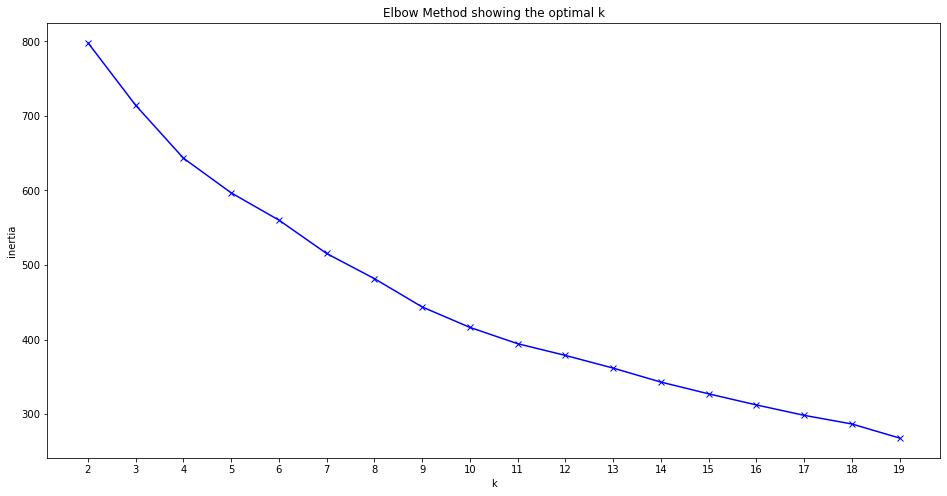

In [35]:
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(feat_prep)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

It's very unclear which K is best through the Elbow Method. We will check Silhouette to see if it sheds some new light.

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

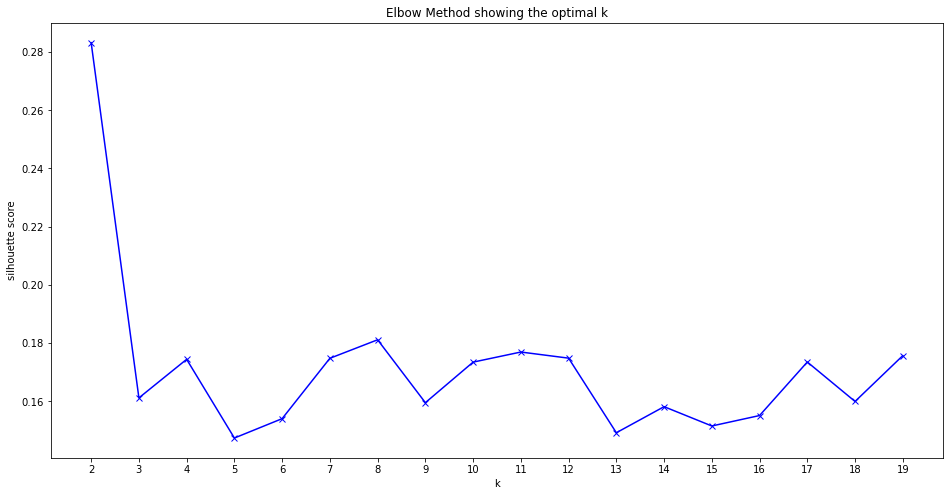

In [36]:
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(feat_prep)
    silhouette.append(silhouette_score(feat_prep, kmeans.predict(feat_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

### Clustering the Features with KMeans

In [37]:
kmeans = KMeans(n_clusters=10, random_state=1234)
kmeans.fit(feat_prep)

KMeans(n_clusters=10, random_state=1234)

In [38]:
clusters = kmeans.predict(feat_prep)
pd.Series(clusters).value_counts().sort_index()

0     2
1     8
2    15
3    12
4     5
5    15
6    15
7    13
8     2
9     7
dtype: int64

In [39]:
feat_df = pd.DataFrame(feat_prep)
feat_df["cluster"] = clusters
feat_df.head()

,0,1,2,3,4,5,6,7,8,9,10,cluster
0,0.399937,-0.122314,1.397958,0.026076,0.770208,-0.639851,0.405342,-0.30155,-0.752274,-0.589342,-0.901809,6
1,0.950583,1.119335,-1.483797,0.934702,0.770208,-0.250227,0.455400,-0.30357,-0.596244,1.066548,0.748698,3
2,0.149644,1.133445,-0.042920,0.904777,0.770208,-0.617706,-0.806991,-0.30357,0.282413,1.821707,-0.456039,3
3,0.516741,0.818329,-0.331095,1.106337,-1.298351,1.647373,-0.991234,-0.30357,0.897275,0.311389,-0.761327,1
4,0.861590,0.319789,-0.042920,0.458873,-1.298351,-0.610093,-0.791974,-0.30357,0.712155,-0.689424,-0.813617,5


In [40]:
kmeans.inertia_

416.30681957834474

In [41]:
cluster_df = feat_df[['cluster']].copy()

In [42]:
cluster_df

,cluster
0,6
1,3
2,3
3,1
4,5
...,...
89,3
90,1
91,2
92,6


In [43]:
info_df = songs_200_features[['artist','song','song_lower']].copy()

In [44]:
info_df

,artist,song,song_lower
0,Chris Stapleton,Starting Over,starting over
1,Ariana Grande,Positions,positions
2,Luke Combs,What You See Is What You Get,what you see is what you get
3,Queen,Greatest Hits,greatest hits
4,The Kid LAROI,F*ck Love,f*ck love
...,...,...,...
89,BTS,Love Yourself: Answer,love yourself: answer
90,Toosii,Poetic Pain,poetic pain
91,Bryson Tiller,T R A P S O U L,t r a p s o u l
92,Linkin Park,[Hybrid Theory],[hybrid theory]


In [45]:
info_cluster_df = info_df.merge(cluster_df, left_index = True, right_index = True)

In [46]:
info_cluster_df

,artist,song,song_lower,cluster
0,Chris Stapleton,Starting Over,starting over,6
1,Ariana Grande,Positions,positions,3
2,Luke Combs,What You See Is What You Get,what you see is what you get,3
3,Queen,Greatest Hits,greatest hits,1
4,The Kid LAROI,F*ck Love,f*ck love,5
...,...,...,...,...
89,BTS,Love Yourself: Answer,love yourself: answer,3
90,Toosii,Poetic Pain,poetic pain,1
91,Bryson Tiller,T R A P S O U L,t r a p s o u l,2
92,Linkin Park,[Hybrid Theory],[hybrid theory],6


# ---------------------

# 2. User Input

Defining a function to receive user input on a song he/she likes. If the song is in The Hot 100, it will return three more recommendations from the same list, and one recommendation from an alternative dataframe. The objective of doing this is to introduce the user to music that he/she would usually not get access to via the main radio stations. If the input song is not in The Hot 100, the user will be told that his preferred song is not within The Top 100. 

In [47]:
#tainted love, wonderwall
WAP = sp.search(q='tainted love', limit=1) 
WAP["tracks"]["items"][0]["uri"]
user_features = sp.audio_features(WAP["tracks"]["items"][0]["uri"])
user_features

[{'danceability': 0.542,
  'energy': 0.45,
  'key': 7,
  'loudness': -9.931,
  'mode': 0,
  'speechiness': 0.0361,
  'acousticness': 0.558,
  'instrumentalness': 6.43e-06,
  'liveness': 0.579,
  'valence': 0.626,
  'tempo': 144.437,
  'type': 'audio_features',
  'id': '58E1XVmZTODC67YNjneuXM',
  'uri': 'spotify:track:58E1XVmZTODC67YNjneuXM',
  'track_href': 'https://api.spotify.com/v1/tracks/58E1XVmZTODC67YNjneuXM',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/58E1XVmZTODC67YNjneuXM',
  'duration_ms': 153840,
  'time_signature': 4}]

In [48]:
user_features[0]['danceability']

0.542

In [49]:
feature_list = {'danceability':[user_features[0]['danceability']],'energy':[user_features[0]['energy']], 'key':[user_features[0]['key']],'loudness':[user_features[0]['loudness']],'mode':[user_features[0]['mode']],'speechiness':[user_features[0]['speechiness']],'acousticness':[user_features[0]['acousticness']],'instrumentalness':[user_features[0]['instrumentalness']],'liveness':[user_features[0]['liveness']],'valence':[user_features[0]['valence']],'tempo':[user_features[0]['tempo']]}
feature_list_df = pd.DataFrame(data=feature_list)
feature_list_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.542,0.45,7,-9.931,0,0.0361,0.558,0.000006,0.579,0.626,144.437


In [50]:
scaled_features = scaler.transform(feature_list_df)

In [52]:
song_cluster = kmeans.predict(scaled_features)

In [53]:
song_cluster

array([5])

In [54]:
feature_list_df['cluster'] = song_cluster

In [55]:
feature_list_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,0.542,0.45,7,-9.931,0,0.0361,0.558,0.000006,0.579,0.626,144.437,5


In [56]:
def user_input_200(scaler, kmeans, info_cluster_df):
    song_input = input("Enter your favourite song: ") 
    print()
    song_input = song_input.lower()
    
    # Query
    song_query = sp.search(q=song_input, limit=1) 
    song_query["tracks"]["items"][0]["uri"]
    user_features = sp.audio_features(song_query["tracks"]["items"][0]["uri"])
    
    '''
    user_features[0]['danceability']
    user_features[0]['energy']
    user_features[0]['key']
    user_features[0]['loudness']
    user_features[0]['mode']
    user_features[0]['speechiness']
    user_features[0]['acousticness']
    user_features[0]['instrumentalness']
    user_features[0]['liveness']
    user_features[0]['valence']
    user_features[0]['tempo']
    '''
    
    #feature_list = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']
    
    feature_list = {'danceability':[user_features[0]['danceability']],'energy':[user_features[0]['energy']], 'key':[user_features[0]['key']],'loudness':[user_features[0]['loudness']],'mode':[user_features[0]['mode']],'speechiness':[user_features[0]['speechiness']],'acousticness':[user_features[0]['acousticness']],'instrumentalness':[user_features[0]['instrumentalness']],'liveness':[user_features[0]['liveness']],'valence':[user_features[0]['valence']],'tempo':[user_features[0]['tempo']]}
    feature_list_df = pd.DataFrame(data=feature_list)
    
    scaled_features = scaler.transform(feature_list_df)
    song_cluster = kmeans.predict(scaled_features)
    feature_list_df['cluster'] = song_cluster
    
    #if info_cluster_df.song_lower.isin([song_input]).any() == True:
    sample = info_cluster_df['song'][info_cluster_df.cluster == feature_list_df.iloc[0]['cluster']].sample(n=3)
    print("Cool, you have the taste of a free spirit! These three songs might free your spirit up even more: ")
    print(list(sample))
#    print(song_cluster)
    #else:
        #sample_tc = the_current_top_89['song'].sample(n=1)
        #print("This song isn't HOT! You might prefer something special that will make you stand out from the HOT crowds: ")
        #print(list(sample_tc))


In [67]:
user_input_200(scaler, kmeans, info_cluster_df)

Enter your favourite song: tainted love

Cool, you have the taste of a free spirit! These three songs might free your spirit up even more: 
['Born To Die', '1', 'The Essential Johnny Cash']


In [60]:
info_cluster_df['song'][info_cluster_df.cluster == 5]

4                     F*ck Love
5                       My Turn
7               So Help Me God!
8          Hollywood's Bleeding
14                  After Hours
27                    Traveller
30                      Over It
42                            1
50                  Born To Die
52                  Free Spirit
62                       Indigo
75           Back From The Edge
78    The Essential Johnny Cash
81       A Love Letter To You 4
85                      Changes
Name: song, dtype: object